# Identify generic genes and pathways

Studies have found that some genes are more likely to be differentially expressed even across a wide range of experimental designs. These generic genes and subsequent pathways are not necessarily specific to the biological process being studied but instead represent a more systematic change. 

We have developed an approach, outlined below, to automatically identify these generic genes and pathways. We have validated this simulation approach can identify generic genes and pathways in the analysis notebooks: [human_general_analysis](../human_general_analysis/) and [human_cancer_analysis](../human_cancer_analysis/). Here

This notebook applies this approach to identify generic genes and pathways in the pseudomonas compendium. 

**Steps to identify generic genes:**
1. Simulates N gene expression experiments using [ponyo](https://github.com/ajlee21/ponyo)
2. Perform DE analysis to get association statistics for each gene

In this case the DE analysis is based on the experimental design of the template experiment, described in the previous [notebook](1_process_pseudomonas_data.ipynb). 
The template experiment is [GEOD-33245](https://www.ebi.ac.uk/arrayexpress/experiments/E-GEOD-33245/?s_sortby=col_8&s_sortorder=ascending), which contains multiple different comparisons including WT vs *crc* mutants, WT vs *cbr* mutants in different conditions. So the DE analysis is comparing WT vs mutant.

3. For each gene, aggregate statistics across all simulated experiments 
4. Rank genes based on this aggregated statistic

**Steps to identify generic gene sets (pathways):**
1. Using the same simulated experiments from above, perform GSEA analysis. This analysis will determine whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list of genes, where genes are ranked by log fold change, indicating a correlation with change in expression.
2. For each gene set (pathway), aggregate statistics across all simulated experiments
3. Rank gene sets based on this aggregated statistic

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from rpy2.robjects import pandas2ri
pandas2ri.activate()

from ponyo import utils, simulate_expression_data
from generic_expression_patterns_modules import process, stats, ranking

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_filename = os.path.abspath(os.path.join(base_dir,
                                           "configs",
                                           "config_pseudomonas_33245.tsv"))
params = utils.read_config(config_filename)

In [3]:
# Load params
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
num_runs = params['num_simulated']
project_id = params['project_id']
metadata_col_id = params['metadata_colname']
raw_template_filename = params['raw_template_filename']
processed_template_filename = params['processed_template_filename']
normalized_compendium_filename = params['normalized_compendium_filename']
scaler_filename = params['scaler_filename']
col_to_rank_genes = params['rank_genes_by']
col_to_rank_pathways = params['rank_pathways_by']
statistic = params['gsea_statistic']

# Load metadata file with grouping assignments for samples
sample_id_metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv")

# Load metadata file with grouping assignments for samples
metadata_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_groups.tsv"
)

# Load pickled file
scaler = pickle.load(open(scaler_filename, "rb"))

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
# Output files
gene_summary_filename = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_gene_summary_{project_id}.tsv"
)
pathway_summary_filename = os.path.join(
    base_dir, 
    dataset_name, 
    f"generic_pathway_summary_{project_id}.tsv"
)

### Simulate experiments using selected template experiment
Workflow:

1. Get the gene expression data for the selected template experiment
2. Encode this experiment into a latent space using the trained VAE model
3. Linearly shift the encoded template experiment in the latent space
4. Decode the samples. This results in a new experiment
5. Repeat steps 1-4 to get multiple simulated experiments

In [5]:
# Simulate multiple experiments
# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:           
#   - selected_simulated_data_SRP012656_<n>.txt
#   - selected_simulated_encoded_data_SRP012656_<n>.txt
#   - template_normalized_data_SRP012656_test.txt
# in which "<n>" is an integer in the range of [0, num_runs-1] 
os.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)
for run_id in range(num_runs):
    simulate_expression_data.shift_template_experiment(
        normalized_compendium_filename,
        project_id,
        metadata_col_id,
        NN_architecture,
        dataset_name,
        scaler,
        local_dir,
        base_dir,
        run_id)

'# Simulate multiple experiments\n# This step creates the following files in "<local_dir>/pseudo_experiment/" directory:           \n#   - selected_simulated_data_SRP012656_<n>.txt\n#   - selected_simulated_encoded_data_SRP012656_<n>.txt\n#   - template_normalized_data_SRP012656_test.txt\n# in which "<n>" is an integer in the range of [0, num_runs-1] \nos.makedirs(os.path.join(local_dir, "pseudo_experiment"), exist_ok=True)\nfor run_id in range(num_runs):\n    simulate_expression_data.shift_template_experiment(\n        normalized_compendium_filename,\n        project_id,\n        metadata_col_id,\n        NN_architecture,\n        dataset_name,\n        scaler,\n        local_dir,\n        base_dir,\n        run_id)'

### Process template and simulated data

* Remove samples not required for comparison. 
* Make sure ordering of samples matches metadata for proper comparison

In [6]:
if not os.path.exists(sample_id_metadata_filename):
    sample_id_metadata_filename = None

stats.process_samples_for_limma(
    raw_template_filename,
    metadata_filename,
    processed_template_filename,
    sample_id_metadata_filename,
)

for i in range(num_runs):
    simulated_filename = os.path.join(
        local_dir,
        "pseudo_experiment",
        f"selected_simulated_data_{project_id}_{i}.txt"
    )
    stats.process_samples_for_limma(
        simulated_filename,
        metadata_filename,
        None,
        sample_id_metadata_filename,
)

'if not os.path.exists(sample_id_metadata_filename):\n    sample_id_metadata_filename = None\n\nstats.process_samples_for_limma(\n    raw_template_filename,\n    metadata_filename,\n    processed_template_filename,\n    sample_id_metadata_filename,\n)\n\nfor i in range(num_runs):\n    simulated_filename = os.path.join(\n        local_dir,\n        "pseudo_experiment",\n        f"selected_simulated_data_{project_id}_{i}.txt"\n    )\n    stats.process_samples_for_limma(\n        simulated_filename,\n        metadata_filename,\n        None,\n        sample_id_metadata_filename,\n)'

In [7]:
# Quick check
template_data = pd.read_csv(
    processed_template_filename, 
    header=0,
    index_col=0,
    sep="\t"
)

assert(template_data.shape[0] == 4)

### Differential expression analysis

In [8]:
# Create subdirectory: "<local_dir>/DE_stats/"
os.makedirs(os.path.join(local_dir, "DE_stats"), exist_ok=True)

In [9]:
%%R -i metadata_filename -i project_id -i processed_template_filename -i local_dir -i base_dir

source(paste0(base_dir, '/generic_expression_patterns_modules/DE_analysis.R'))

get_DE_stats_limma(metadata_filename,
                   project_id, 
                   processed_template_filename,
                   "template",
                   local_dir,
                   "real")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: S4Vectors

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: stats4

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: BiocGenerics

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: parallel

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘BiocGenerics’


  warnings.warn(x, RRuntimeWarni

[1] 15


In [10]:
%%R -i metadata_filename -i project_id -i base_dir -i local_dir -i num_runs -o num_sign_DEGs_simulated

source(paste0(base_dir,'/generic_expression_patterns_modules/DE_analysis.R'))

num_sign_DEGs_simulated <- c()

for (i in 0:(num_runs-1)){
    simulated_data_filename <- paste(
        local_dir, 
        "pseudo_experiment/selected_simulated_data_",
        project_id,
        "_", 
        i,
        ".txt",
        sep=""
    )
    
    run_output <- get_DE_stats_limma(
        metadata_filename,
        project_id, 
        simulated_data_filename,
        "simulated",
        local_dir,
        i
    )
    num_sign_DEGs_simulated <- c(num_sign_DEGs_simulated, run_output)
}

### Rank genes

In [11]:
analysis_type = "DE"
template_DE_stats_filename = os.path.join(
    local_dir,
    "DE_stats",
    f"DE_stats_template_data_{project_id}_real.txt"
)
template_DE_stats, simulated_DE_summary_stats = ranking.process_and_rank_genes_pathways(
    template_DE_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_genes,
)

### Gene summary table

In [12]:
summary_gene_ranks = ranking.generate_summary_table(
    template_DE_stats_filename,
    template_DE_stats,
    simulated_DE_summary_stats,
    col_to_rank_genes,
    local_dir,
    'gene',
    params
)

summary_gene_ranks.sort_values(by="Z score", ascending=False).head()

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Gene ID,Adj P-value (Real),Rank (Real),abs(logFC) (Real),logFC (Real),Median adj p-value (simulated),Rank (simulated),Mean abs(logFC) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
PA4726,PA4726,0.000010,5549.0,4.530917,-4.530917,0.846422,4845.5,0.16708,0.101184,25,43.127565
PA1123,PA1123,0.002578,5537.0,2.175900,-2.175900,0.682483,4391.5,0.16190,0.106530,25,18.905485
PA4620,PA4620,0.001107,5512.0,1.611311,1.611311,0.842271,2220.5,0.11220,0.092593,25,16.190288
PA1217,PA1217,0.001039,5531.0,1.941753,1.941753,0.850699,1612.0,0.11886,0.120587,25,15.116766
PA1216,PA1216,0.000223,5545.0,2.600594,2.600594,0.832988,3823.5,0.19604,0.159747,25,15.052271


In [13]:
# Add gene name as column to summary dataframe
summary_gene_ranks = ranking.add_pseudomonas_gene_name_col(summary_gene_ranks, base_dir)
summary_gene_ranks.sort_values(by="Z score", ascending=False).head()

,Gene ID,Adj P-value (Real),Rank (Real),abs(logFC) (Real),logFC (Real),Median adj p-value (simulated),Rank (simulated),Mean abs(logFC) (simulated),Std deviation (simulated),Number of experiments (simulated),Z score,Gene Name
PA4726,PA4726,0.000010,5549.0,4.530917,-4.530917,0.846422,4845.5,0.16708,0.101184,25,43.127565,cbrB
PA1123,PA1123,0.002578,5537.0,2.175900,-2.175900,0.682483,4391.5,0.16190,0.106530,25,18.905485,NaN
PA4620,PA4620,0.001107,5512.0,1.611311,1.611311,0.842271,2220.5,0.11220,0.092593,25,16.190288,NaN
PA1217,PA1217,0.001039,5531.0,1.941753,1.941753,0.850699,1612.0,0.11886,0.120587,25,15.116766,NaN
PA1216,PA1216,0.000223,5545.0,2.600594,2.600594,0.832988,3823.5,0.19604,0.159747,25,15.052271,NaN


In [14]:
# Check if there is an NaN values, there should not be
summary_gene_ranks.isna().any()

Gene ID                              False
Adj P-value (Real)                   False
Rank (Real)                          False
abs(logFC) (Real)                    False
logFC (Real)                         False
Median adj p-value (simulated)       False
Rank (simulated)                     False
Mean abs(logFC) (simulated)          False
Std deviation (simulated)            False
Number of experiments (simulated)    False
Z score                              False
Gene Name                             True
dtype: bool

In [15]:
# Create `gene_summary_filename`
summary_gene_ranks.to_csv(gene_summary_filename, sep='\t')

## Compare gene ranking

r = 0.44880008139441796
p = 2.8537129367217363e-273
ci_low = 0.4247636166550418
ci_high = 0.4699706464271449


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/font_manager.py:1238: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


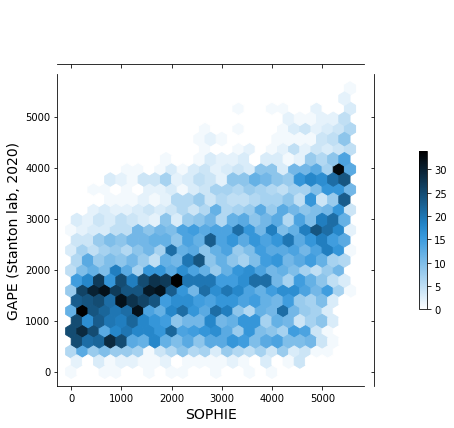

In [16]:
# Get generic genes identified by Crow et. al.
GAPE_filename = params['reference_gene_filename']
ref_gene_col = params['reference_gene_name_col']
ref_rank_col = params['reference_rank_col']

figure_filename = f"gene_ranking_{col_to_rank_genes}.svg"

corr, shared_ranking = ranking.compare_gene_ranking(
    summary_gene_ranks,
    GAPE_filename,
    ref_gene_col,
    ref_rank_col,
    figure_filename
)

In [17]:
# Get genes that are highly generic in both
generic_both = shared_ranking[(shared_ranking["Rank (simulated)"]>4500) & (shared_ranking["prop DEGs"]>3500)]
generic_both.to_csv(os.path.join(local_dir, "SOPHIE_GAPE_generic.tsv"), sep="\t")

In [18]:
# Get genes that are highly generic by SOPHIE but not by GAPE
generic_SOPHIE_only = shared_ranking[(shared_ranking["Rank (simulated)"]>4500) & (shared_ranking["prop DEGs"]<2000)]
generic_SOPHIE_only.to_csv(os.path.join(local_dir, "SOPHIE_generic_only.tsv"), sep="\t")

**Takeaway:**

* X-axis: gene ranking using SOPHIE (trained on Pseudomonas compendium containing ~1K experiments)
* Y-axis: gene ranking using GAPE (curated set of 73 experiments)

* Overall there is good consistency between SOPHIE and the reference set of experiments. There is especially more consistency amongst lowly ranked genes (genes that consistently didn’t change or genes that changed in a subset of cases). Perhaps the signal from these low ranked genes are very robust in P. aeruginosa
  * Housekeeping genes make sense as contributing to a very strong consistent signal.
  * What about those inconsistently DE genes? Assuming the 73 contexts are represented in the compendium, then those genes that are in consisten
* There is some noise in the bottom right corner (i.e. genes that the reference didn't think were as generic but SOPHIE did). These might be the result of the reference being limited to 73 experiments and differences in data processing (ANOVA vs RMA).
  * Assuming the 73 contexts are represented in the compendium, if a gene is generic in the compendium, then this gene was found to be DE across many contexts, including the subset of 73 contexts. We suspect the reason for generic genes being highly generic in the compendium but NOT in the 73 experiments is because the signal to noise ratio will be lower in the smaller subset that reduce the generic signal.

### GSEA 
**Goal:** To detect modest but coordinated changes in prespecified sets of related genes (i.e. those genes in the same pathway or share the same GO term).

1. Ranks all genes based using DE association statistics. 
2. An enrichment score (ES) is defined as the maximum distance from the middle of the ranked list. Thus, the enrichment score indicates whether the genes contained in a gene set are clustered towards the beginning or the end of the ranked list (indicating a correlation with change in expression). 
3. Estimate the statistical significance of the ES by a phenotypic-based permutation test in order to produce a null distribution for the ES( i.e. scores based on permuted phenotype)

In [19]:
# Create "<local_dir>/GSEA_stats/" subdirectory
os.makedirs(os.path.join(local_dir, "GSA_stats"), exist_ok=True)

In [20]:
# Load pathway data
adage_kegg_DB_filename = params['pathway_DB_filename']

In [21]:
# Need to format data into tab-delimited matrix
# with columns= KEGG pathway name, description, gene ids
# Each gene ids is tab separated
adage_kegg_DB_processed_filename = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    "adage_kegg_DB_process_filename.gmt"
)
stats.format_pseudomonas_pathway_DB(adage_kegg_DB_filename, local_dir, adage_kegg_DB_processed_filename)

In [22]:
%%R -i base_dir -i template_DE_stats_filename -i adage_kegg_DB_processed_filename -i statistic -o template_enriched_pathways

source(paste0(base_dir, '/generic_expression_patterns_modules/GSEA_analysis.R'))

out_filename <- paste(local_dir, 
                     "GSA_stats/GSEA_stats_template_data_",
                     project_id,
                     "_real.txt", 
                     sep = "")

template_enriched_pathways <- find_enriched_pathways(template_DE_stats_filename, adage_kegg_DB_processed_filename, statistic)
write.table(as.data.frame(template_enriched_pathways[1:7]), file = out_filename, row.names = F, sep = "\t")

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: Rcpp

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


In [23]:
print(template_enriched_pathways.shape)
template_enriched_pathways[template_enriched_pathways['padj'] < 0.05].sort_values(by='padj').head()

(169, 8)


,pathway,pval,padj,ES,NES,nMoreExtreme,size,leadingEdge
168,"KEGG-Module-M00178: Ribosome, bacteria",0.000113,0.001271,0.914364,6.108502,0.0,55,None
50,KEGG-Pathway-pae03010: Ribosome - Pseudomonas ...,0.000113,0.001271,0.914364,6.108502,0.0,55,None
49,KEGG-Pathway-pae03018: RNA degradation - Pseud...,0.000138,0.001271,0.700591,2.796353,0.0,14,None
48,KEGG-Pathway-pae00330: Arginine and proline me...,0.000110,0.001271,0.362552,2.609733,0.0,69,None
47,KEGG-Pathway-pae00030: Pentose phosphate pathw...,0.000127,0.001271,0.533769,2.640694,0.0,24,None


In [24]:
%%R -i project_id -i local_dir -i adage_kegg_DB_processed_filename -i num_runs -i statistic

source(paste0(base_dir, '/generic_expression_patterns_modules/GSEA_analysis.R'))

# New files created: "<local_dir>/GSEA_stats/GSEA_stats_simulated_data_<project_id>_<n>.txt"
for (i in 0:(num_runs-1)) {
    simulated_DE_stats_filename <- paste(local_dir, 
                                     "DE_stats/DE_stats_simulated_data_", 
                                     project_id,
                                     "_", 
                                     i,
                                     ".txt",
                                     sep = "")
    
    out_filename <- paste(local_dir, 
                     "GSA_stats/GSEA_stats_simulated_data_",
                     project_id,
                     "_",
                     i,
                     ".txt", 
                     sep = "")
    
    enriched_pathways <- find_enriched_pathways(simulated_DE_stats_filename, adage_kegg_DB_processed_filename, statistic) 
    
    # Remove column with leading edge since its causing parsing issues
    write.table(as.data.frame(enriched_pathways[1:7]), file = out_filename, row.names = F, sep = "\t")
}

### Rank pathways 

In [25]:
analysis_type = "GSA"
template_GSEA_stats_filename = os.path.join(
    local_dir,
    "GSA_stats",
    f"GSEA_stats_template_data_{project_id}_real.txt"    
)
template_GSEA_stats, simulated_GSEA_summary_stats = ranking.process_and_rank_genes_pathways(
    template_GSEA_stats_filename,
    local_dir,
    num_runs,
    project_id,
    analysis_type,
    col_to_rank_pathways,
    "GSEA"
)

### Pathway summary table

In [26]:
# Create intermediate file: "<local_dir>/gene_summary_table_<col_to_rank_pathways>.tsv"
summary_pathway_ranks = ranking.generate_summary_table(
    template_GSEA_stats_filename,
    template_GSEA_stats,
    simulated_GSEA_summary_stats,
    col_to_rank_pathways,
    local_dir,
    'pathway',
    params
)

summary_pathway_ranks.sort_values(by='Rank (simulated)', ascending=False).head()

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


,Pathway ID,Adj P-value (Real),Rank (Real),padj (Real),Median adj p-value (simulated),Rank (simulated),Mean padj (simulated),Std deviation (simulated),Number of experiments (simulated),Z score
pathway,,,,,,,,,,
"KEGG-Module-M00178: Ribosome, bacteria","KEGG-Module-M00178: Ribosome, bacteria",0.001271,159.5,0.001271,0.001355,162.0,0.001335,0.000233,25,-0.274735
KEGG-Pathway-pae00240: Pyrimidine metabolism - Pseudomonas aeruginosa PAO1,KEGG-Pathway-pae00240: Pyrimidine metabolism -...,0.001271,159.5,0.001271,0.001355,162.0,0.001335,0.000233,25,-0.274735
KEGG-Pathway-pae00190: Oxidative phosphorylation - Pseudomonas aeruginosa PAO1,KEGG-Pathway-pae00190: Oxidative phosphorylati...,0.001271,159.5,0.001271,0.001355,162.0,0.001335,0.000233,25,-0.274735
KEGG-Pathway-pae00970: Aminoacyl-tRNA biosynthesis - Pseudomonas aeruginosa PAO1,KEGG-Pathway-pae00970: Aminoacyl-tRNA biosynth...,0.001271,159.5,0.001271,0.001355,162.0,0.001335,0.000233,25,-0.274735
"KEGG-Module-M00009: Citrate cycle (TCA cycle, Krebs cycle)","KEGG-Module-M00009: Citrate cycle (TCA cycle, ...",0.001271,159.5,0.001271,0.001355,162.0,0.001335,0.000233,25,-0.274735


In [27]:
# Create `pathway_summary_filename`
summary_pathway_ranks.to_csv(pathway_summary_filename, sep='\t')

**Quick check:**

Looks like Ribosomes are found to be significantly differentiated in the template and across 25 simulated experiments. So this pathway looks to be generic, which is consistent with findings from [Crow. et. al.](https://www.pnas.org/content/116/13/6491.abstract), using Human data. This is also consistent with [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2679180/) which observed that Ribosome proteins have many different functions in *S. cerevisiae*, which might explain their variability across a wide range of contexts.

* Need to think about why it might make sense that Ribosomes being generic in Humans would also imply that they are generic in P. aeruginosa.